# Assignment 4 Isolation Forests

### David Nicolay 26296918

In [75]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import json
from time import time
import warnings
warnings.filterwarnings('ignore')


# import my utils
import sys
sys.path.append('../')
from src.plots import plot_f1_vs_param_size, plot_training_time_vs_param_size
from src.modelling import evaluate_isolation_forest, evaluate_isolation_forest_with_std

## Data Preparation


In [76]:
dataset = 'shuttle'

In [77]:
df_np = np.load('../datasets/{}.npz'.format(dataset))

In [78]:
# convert to dataframe
df = pd.DataFrame(df_np['X'], columns=[f'feature_{i}' for i in range(df_np['X'].shape[1])])
df['label'] = df_np['y']

In [79]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1
...,...,...,...,...,...,...,...,...,...,...
49092,39,-2,80,-4,38,0,41,41,0,0
49093,43,0,81,1,42,-9,37,39,2,0
49094,49,0,87,0,46,-12,38,41,2,0
49095,80,0,84,0,-36,-29,4,120,116,1


In [80]:
# Explore the data
print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nAnomaly percentage: {(df['label'] == -1).sum() / len(df) * 100:.2f}%")
print(f"\nFeature statistics:")
print(df.drop('label', axis=1).describe())

Dataset shape: (49097, 10)

Label distribution:
label
0    45586
1     3511
Name: count, dtype: int64

Anomaly percentage: 0.00%

Feature statistics:
          feature_0     feature_1     feature_2     feature_3     feature_4  \
count  49097.000000  49097.000000  49097.000000  49097.000000  49097.000000   
mean      46.932399     -0.063955     85.123124      0.213231     36.871784   
std       12.875159     84.674481      8.877517     37.579171     19.963113   
min       27.000000  -4821.000000     21.000000  -3939.000000   -188.000000   
25%       37.000000      0.000000     79.000000      0.000000     30.000000   
50%       44.000000      0.000000     83.000000      0.000000     42.000000   
75%       50.000000      0.000000     88.000000      0.000000     46.000000   
max      126.000000   5075.000000    149.000000   3830.000000    436.000000   

          feature_5     feature_6     feature_7     feature_8  
count  49097.000000  49097.000000  49097.000000  49097.000000  
mean      

In [81]:
# Create results directory
results_dir = f'../results/{dataset}'
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

Results will be saved to: ../results/shuttle


In [82]:
# Split data into features and labels
X = df.drop('label', axis=1).values
y = df['label'].values


print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of anomalies: {y.sum()}")
print(f"Number of normal instances: {(y == 0).sum()}")

Feature matrix shape: (49097, 9)
Labels shape: (49097,)
Number of anomalies: 3511
Number of normal instances: 45586


## Modelling

In [83]:
# Define comprehensive parameter grid for Isolation Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_samples': [64, 128, 256, 'auto'],  # Number of samples to draw
    'contamination': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],  # Expected proportion of outliers
    'max_features': [1, 2, 3, 4, 5, 'auto'],  # Number of features to draw
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

print("Control Parameters to be analyzed:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Control Parameters to be analyzed:
  n_estimators: [50, 100, 200, 300, 500]
  max_samples: [64, 128, 256, 'auto']
  contamination: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
  max_features: [1, 2, 3, 4, 5, 'auto']
  bootstrap: [True, False]


In [84]:
# Define base parameters (default/reasonable values)
base_params = {
    'n_estimators': 100,
    'max_samples': 'auto',
    'contamination': 0.1,
    'max_features': 1.0,
    'bootstrap': False,
    'random_state': 12
}

print("Base parameters:")
for param, value in base_params.items():
    print(f"  {param}: {value}")

Base parameters:
  n_estimators: 100
  max_samples: auto
  contamination: 0.1
  max_features: 1.0
  bootstrap: False
  random_state: 12


### Base model to check setup

In [86]:
evaluate_isolation_forest_with_std(X, y, base_params)

{'param_name': None,
 'param_value': None,
 'precision_mean': np.float64(0.7045621181262729),
 'precision_std': np.float64(0.0017524745225497983),
 'precision_min': np.float64(0.7018329938900204),
 'precision_max': np.float64(0.7073319755600814),
 'recall_mean': np.float64(0.9853033323839364),
 'recall_std': np.float64(0.002450768984824723),
 'recall_min': np.float64(0.9814867559099971),
 'recall_max': np.float64(0.9891768726858445),
 'f1_score_mean': np.float64(0.8216126350789692),
 'f1_score_std': np.float64(0.002043617125215426),
 'f1_score_min': np.float64(0.81843011518822),
 'f1_score_max': np.float64(0.8248426552665954),
 'roc_auc_mean': np.float64(0.9974462427147163),
 'roc_auc_std': np.float64(0.0009512243129058646),
 'roc_auc_min': np.float64(0.9956536434313538),
 'roc_auc_max': np.float64(0.9984494832400125),
 'pr_auc_mean': np.float64(0.9802776001985978),
 'pr_auc_std': np.float64(0.006063044094571239),
 'pr_auc_min': np.float64(0.969311843060083),
 'pr_auc_max': np.float64(

## Evaluate Parameter Changes

### Num estimators

In [87]:
# first run on list of lots of parameters
num_est_grid = [
    10, 25, 50, 75, 100, 150, 200, 250,
    300, 350, 400, 450, 500, 600, 700, 800,
    900, 1000, 1250, 1500, 1750, 2000
]


In [ ]:
# run models
n_estimators_results = []
csv_path = os.path.join(results_dir, 'num_est_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path):
    os.remove(csv_path)

for num_est in num_est_grid:
    params = base_params.copy()
    params['n_estimators'] = num_est
    
    print(f"Running Isolation Forest with n_estimators={num_est}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'n_estimators', num_est)
    
    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path):
        result_df.to_csv(csv_path, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path, mode='a', header=False, index=False)
    
    n_estimators_results.append(result)

Running Isolation Forest with n_estimators=10
Running Isolation Forest with n_estimators=25
Running Isolation Forest with n_estimators=50
Running Isolation Forest with n_estimators=75
Running Isolation Forest with n_estimators=100
Running Isolation Forest with n_estimators=150
Running Isolation Forest with n_estimators=200
Running Isolation Forest with n_estimators=250
Running Isolation Forest with n_estimators=300
Running Isolation Forest with n_estimators=350
Running Isolation Forest with n_estimators=400
Running Isolation Forest with n_estimators=450
Running Isolation Forest with n_estimators=500
Running Isolation Forest with n_estimators=600
Running Isolation Forest with n_estimators=700
Running Isolation Forest with n_estimators=800
Running Isolation Forest with n_estimators=900
Running Isolation Forest with n_estimators=1000
Running Isolation Forest with n_estimators=1250


#### 1. Convergence Curve

#### 2. Stability Analysis: Variance reduction

#### 3. Performance over time

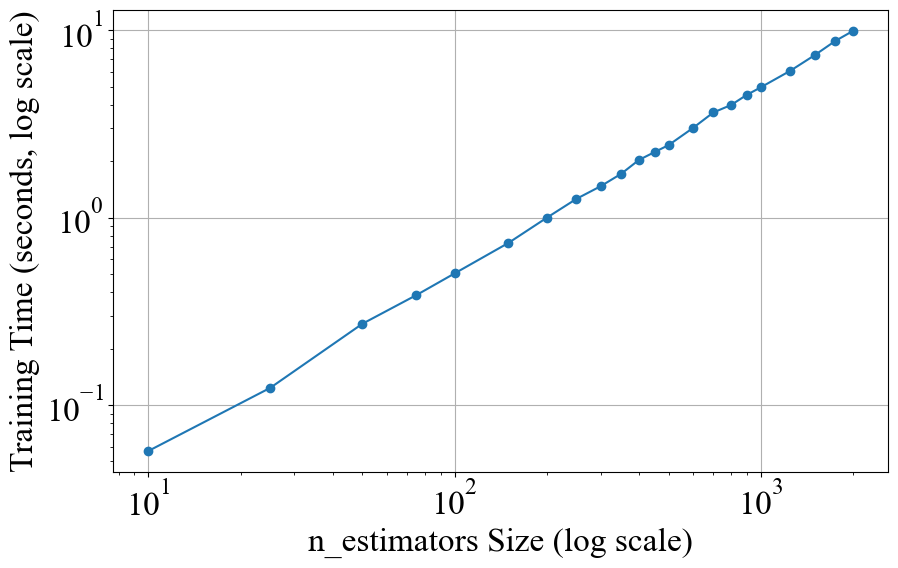

In [72]:
# plot training time vs param size
plot_training_time_vs_param_size(
    param_sizes=num_est_grid,
    training_times=training_times,
    param_name='n_estimators'
    # save_path=os.path.join(results_dir, 'n_estimators_time.png')
)

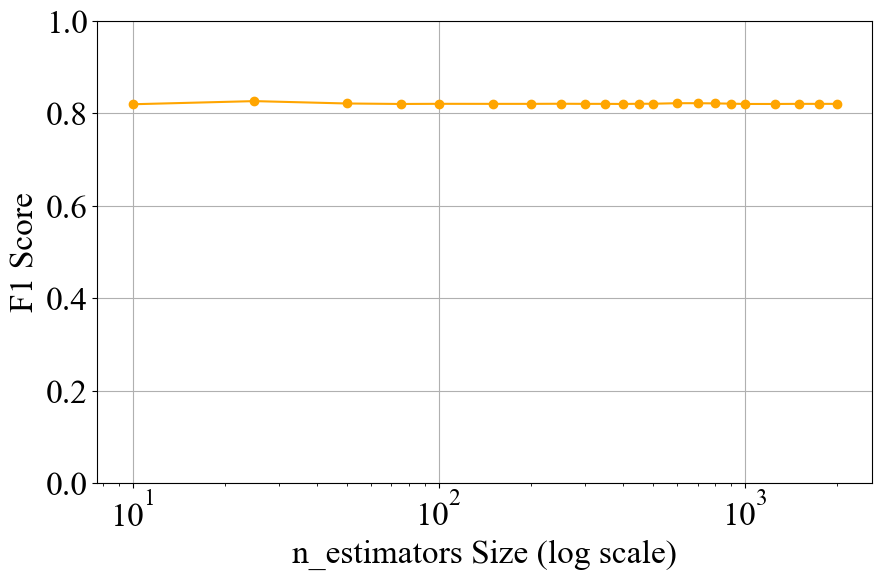

In [73]:
# plot f1 vs param size
plot_f1_vs_param_size(
    param_sizes=num_est_grid,
    f1_scores=f1_scores,
    param_name='n_estimators',
    # save_path=os.path.join(results_dir, 'n_estimators_f1.png')
)

### Max samples